# MitreMap - Inferring MITRE Technique from Threat Intel Reports

## Overview
This notebook allows a user to map descriptive text of an incident on to relevant MITRE ATT&CK Enterprise techniques. It uses a GPT2 language model to associate terms in the description with similar descriptions in past incidents. It also extracts relevant Indicators of Compromise from the text.

Two inference modes are provided:
- semantic (default): Sentence-Transformers similarity between your text and technique descriptions (fast & light)
- zero-shot: Hugging Face zero-shot classification (more compute, but works well)

> Works on CPU.

In [19]:
# install dependencies
%pip -q install -U pandas numpy requests tqdm regex matplotlib
%pip -q install -U transformers sentence-transformers torch --extra-index-url https://download.pytorch.org/whl/cpu
%pip -q install -U iocextract
%pip -q install -U beautifulsoup4 pypdf
%pip -q install -U tldextract idna

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


In [2]:
# imports and setups
import json, re, os, math, time, pathlib, itertools
from pathlib import Path
import requests
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

from IPython.display import display

# NLP models
from transformers import pipeline
from sentence_transformers import SentenceTransformer, util

# visualization
import matplotlib.pyplot as plt

# print out the version of the imported NLP models
import transformers, torch, sentence_transformers, iocextract
print("Versions:")
print("transformers:", transformers.__version__)
print("torch       :", torch.__version__)
print("s-transform :", sentence_transformers.__version__)

W0821 23:29:17.954000 20324 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


Versions:
transformers: 4.55.3
torch       : 2.8.0+cpu
s-transform : 5.1.0


In [3]:
# Fetch & cache the MITRE ATT&CK Enterprise dataset

DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)
ATTACK_JSON = DATA_DIR / "enterprise-attack.json"
ATTACK_JSON_URL = "https://raw.githubusercontent.com/mitre/cti/master/enterprise-attack/enterprise-attack.json"

def fetch_attack_json(force=False, timeout=30):
    if ATTACK_JSON.exists() and not force:
        print(f"Using cached: {ATTACK_JSON}")
        return ATTACK_JSON
    print("Downloading ATT&CK JSON ...")
    r = requests.get(ATTACK_JSON_URL, timeout=timeout)
    r.raise_for_status()
    ATTACK_JSON.write_bytes(r.content)
    print("Saved to ", ATTACK_JSON)
    return ATTACK_JSON

_ = fetch_attack_json(force=False)
# The underscore (_) indicates the return value isn't being used immediately - this is just ensuring the ATT&CK data is available locally.

def load_attack_techniques(json_path=ATTACK_JSON):
    data = json.loads(Path(json_path).read_text(encoding="utf-8"))
    objs = data.get("objects", [])
    tech = []
    for o in objs:
        if o.get("type") != "attack-pattern":
            continue
        name = o.get("name", "")
        desc = o.get("description", "") or ""
        is_sub = bool(o.get("x_mitre_is_subtechnique", False))
        # external_id
        attack_id = None
        for ref in o.get("external_references", []):
            if ref.get("source_name") in ("mitre-attack", "mitre-ics_attack", "mitre-mobile-attack"):
                attack_id = ref.get("external_id")
                break
        # tactics (kill_chain_phases.phase_name)
        tactics = []
        for kcp in o.get("kill_chain_phases", []) or []:
            if kcp.get("kill_chain_name") == "mitre-attack" and kcp.get("phase_name"):
                tactics.append(kcp["phase_name"])
        tactics = sorted(set(tactics))
        if attack_id and name:
            tech.append({
                "technique_id": attack_id,
                "name": name,
                "description": desc,
                "is_subtechnique": is_sub,
                "tactics": tactics
            })
    df = pd.DataFrame(tech).drop_duplicates(subset=["technique_id"]).reset_index(drop=True)
    print(f"Loaded {len(df)} techniques from MITRE ATT&CK.")
    return df

techniques_df = load_attack_techniques()
techniques_df.head()

Using cached: data\enterprise-attack.json
Loaded 823 techniques from MITRE ATT&CK.


,technique_id,name,description,is_subtechnique,tactics
0,T1055.011,Extra Window Memory Injection,Adversaries may inject malicious code into pro...,True,"[defense-evasion, privilege-escalation]"
1,T1053.005,Scheduled Task,Adversaries may abuse the Windows Task Schedul...,True,"[execution, persistence, privilege-escalation]"
2,T1205.002,Socket Filters,Adversaries may attach filters to a network so...,True,"[command-and-control, defense-evasion, persist..."
3,T1066,Indicator Removal from Tools,If a malicious tool is detected and quarantine...,False,[defense-evasion]
4,T1560.001,Archive via Utility,Adversaries may use utilities to compress and/...,True,[collection]


In [ ]:
# IOC extraction
import iocextract, re
from urllib.parse import urlparse
import tldextract
from pathlib import Path

# cache PSL locally
DATA_DIR = Path("data"); DATA_DIR.mkdir(exist_ok=True)
_tld = tldextract.TLDExtract(cache_dir=str(DATA_DIR / "tld_cache"),
                             suffix_list_urls=None)

_ipv4_full = re.compile(r'^(?:\d{1,3}\.){3}\d{1,3}$')

# common defangs
def _refang_text(s: str) -> str:
    rep = [('hxxps://','https://'), ('hxxp://','http://'),
           ('hxxps','https'), ('hxxp','http'),
           ('[.]','.'), ('(.)','.'), ('{.}','.'), ('[dot]','.'),
           ('[:]',':'), ('[//]','//'), ('[://]','://')]
    for a,b in rep: s = s.replace(a,b)
    return s

# conservative token finder, sequences with at least one dot and letters
_token_re = re.compile(r'\b[^\s/\\]+\.[^\s/\\]+\b', re.IGNORECASE)

# extensions that are definitely NOT TLDs
_BAD_SUFFIX = {
    "exe","dll","sys","txt","log","bat","msi","pdb","pdb","dat","rar","zip","gz","7z",
    "ini","cfg","config","json","xml","csv","doc","docx","xls","xlsx","ppt","pptx","bin","msi"
}

def _fqdn_from_host(host: str) -> str | None:
    host = host.strip().strip(".").lower()
    if not host or " " in host or "/" in host or _ipv4_full.match(host):
        return None
    parts = _tld(host)
    if not parts.suffix or parts.suffix.split(".")[-1] in _BAD_SUFFIX or not parts.domain:
        return None
    # keep full FQDN
    fqdn = ".".join([p for p in [parts.subdomain, parts.domain, parts.suffix] if p])
    return fqdn or None

def _extract_domains(text: str, urls: list[str]) -> list[str]:
    doms = set()

    # hosts from URLs
    for u in urls:
        try:
            host = urlparse(u).netloc.split("@")[-1].split(":")[0]
            fqdn = _fqdn_from_host(host)
            if fqdn: doms.add(fqdn)
        except Exception:
            pass

    # defanged tokens
    tx = _refang_text(text)
    for m in _token_re.finditer(tx):
        fqdn = _fqdn_from_host(m.group(0))
        if fqdn: doms.add(fqdn)

    return sorted(doms)

def extract_iocs(text: str):
    urls = list(iocextract.extract_urls(text, refang=True))
    ips = list(iocextract.extract_ips(text))
    emails = list(iocextract.extract_emails(text))
    md5 = list(iocextract.extract_md5_hashes(text))
    sha1 = list(iocextract.extract_sha1_hashes(text))
    sha256 = list(iocextract.extract_sha256_hashes(text))
    domains = _extract_domains(text, urls)

    def dedupe(seq):
        seen, out = set(), []
        for x in seq:
            if x not in seen:
                seen.add(x); out.append(x)
        return out

    return {
        "urls": dedupe(urls),
        "domains": dedupe(domains),
        "ips": dedupe(ips),
        "emails": dedupe(emails),
        "md5": dedupe(md5),
        "sha1": dedupe(sha1),
        "sha256": dedupe(sha256),
    }

def iocs_to_frame(iocs: dict):
    rows = []
    for k, vals in iocs.items():
        for v in vals:
            rows.append({"type": k, "value": v})
    return pd.DataFrame(rows)

print("IOC extractor (PSL-aware) ready.")

IOC extractor (PSL-aware) ready.


In [21]:
# IOC extraction test
_test = """
hxxps[:]//update.micfosoft.com served payload. Files: cmd.exe, mpclient.dll, data.txt.
Email: admin@proton.me. Also research.checkpoint.com referenced. IP 45.77.23.10.
"""
iocs = extract_iocs(_test)
iocs

{'urls': ['https://update.micfosoft.com'],
 'domains': ['proton.me', 'research.checkpoint.com', 'update.micfosoft.com'],
 'ips': [],
 'emails': ['admin@proton.me'],
 'md5': [],
 'sha1': [],
 'sha256': []}

> **Semantic Search** -> Semantic search is a search approach that finds results based on **meaning and context** rather than just exact keyword matches.

Semantic search understands meaning and relationships between concepts.
For example, search for "data theft" can find relevant techniques likt "exfiltration over C2 channel", "data staged", "archive collected data", and "automated collection". It handles context, synonyms, and conceptual relationships.

How semantic search works?
1. Text embedding: converts text into high-dimensional numerical vectors that capture semantic meaning.
2. Vector Similarity: measures how "close" different pieces of text are in this semantic space.
3. Contextual understanding: similar concepts cluster together in the vector space, even with different wording.

In [22]:
# Semantic mode (fast & light)
#precompute technique embeddings (name + description)
model_sem = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
#combine technique name and description with a period seperator; use .fillna("") to handle missing descriptions; create a list of text strings for each technique.
tech_texts = (techniques_df["name"] + ". " + techniques_df["description"].fillna("")).tolist()
#convert all technique texts into numerical vectors; keep results as tensors for faster computation; ensure vectors have unit length for better similarity.                                                                                                                                     
tech_emb = model_sem.encode(tech_texts, convert_to_tensor=True, normalize_embeddings=True)

#semantic search function
def semantic_rank(text:str, top_k: int = 25):
    q_emb = model_sem.encode([text], convert_to_tensor=True, normalize_embeddings=True) # query processing, convert the input query text into the same vector space as the techniques
    sims = util.cos_sim(q_emb, tech_emb).cpu().numpy().ravel()  # similarity calculation, calculate cosine similarity between query and all technique embeddings; cosine similarity measures the angle between vectors (0-1, 1=identical); .ravel() flattens the result into a 1D array
    idx = np.argsort(-sims)[:top_k]
    out = techniques_df.iloc[idx].copy()
    out["score"] = sims[idx]    # ranking and results, sort by similarity and takes top K results; retrieve corresponding technique data and add similarity score.
    return out[["technique_id","name","tactics","is_subtechnique","score"]]

> Zero-shot classification explained:

Zero-shot classification can classify text into categories it has never been explicitly trained on. It works by:
1. Taking input text and a list of possible labels.
2. Using NLI to determine how well the text "entails" each label.
3. Returning confidence scores for each potential match.

> BART MNLI explained:

BART MNLI is a specific natural language processing model that combines two important components:
1. BART (Bidirectional and Auto-Regressive Transformers)
   - A sequence-to-sequence model developed by Facebook.
   - Use a **denoising autoencoder** approach, it's trained by corrupting text and learning to reconstruct it.
   - Combine bidirectional encoder (like BERT) with auto-regressive decoder (like GPT).
   - Excellent at understanding and generating text.
2. MNLI (Multi_Genre Natural Language Inference)
   - A large dataset containing premise-hypothesis pairs.
   - Task: determine if a hypothesis is entailed, contradicted, or neutral given a premise.
   - "Multi-Genre" means it covers diverse text types: news, fiction, government reports, etc.

In [23]:
# zero-shot mode (NLI - Natural Language Inference)
#use BART MNLI by default, fall back to DistilBERT MNLI if memory is tight

# model setup with fallback
def _make_zero_shot_pipeline(): # device=-1 forces CPU usage
    try:
        return pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=-1)
    except Exception as e:
        print("Falling back to distilbert mnli due to: ", e)
        return pipeline("zero-shot-classification", model="typeform/distilbert-base-uncased-mnli", device=-1)

zsc = _make_zero_shot_pipeline()

# classify against technique names, create labels like "Process Injection (T1055)" combining technique name with ID for easy parsing.
labels = (techniques_df["name"] + " (" + techniques_df["technique_id"] + ")").tolist()

# classification function
def zero_shot_rank(text: str, top_k: int=25, batch=50):
    #Hugging Face pipelines can handle many labels but it's faster to batch
    scores = []
    for i in range(0, len(labels), batch):  # processing in batches of 50
        chunk = labels[i:i+batch]
        res = zsc(text, candidate_labels=chunk, hypothesis_template="This text is about {}.", multi_label=True)
        # score extraction and aggregation
        for lab, sc in zip(res["labels"], res["scores"]):
            #extract technique_id from "(Txxxx)" suffix
            tid = lab.split("(")[-1].rstrip(")")
            scores.append((tid, sc))
    #aggregate scores across batches
    agg = {}
    for tid, sc in scores:
        agg[tid] = max(sc, agg.get(tid, 0.0))
    #build dataframe
    df = techniques_df.set_index("technique_id").loc[list(agg.keys())].copy()
    df["score"] = df.index.map(agg.get)
    df = df.sort_values("score", ascending=False).head(top_k).reset_index()
    return df[["technique_id","name","tactics","is_subtechnique","score"]]

Device set to use cpu


In [24]:
# Visualization
def plot_topk(df, title="Top techniques"):
    topk = df.sort_values("score", ascending=False).head(10)
    plt.figure(figsize=(8, max(3, 0.35*len(topk))))
    plt.barh(topk["technique_id"] + " " + topk["name"], topk["score"])
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.xlabel("score")
    plt.tight_layout()
    plt.show()

def tactic_heatmap(df, title="Tactic coverage (sum of scores)"):
    ex = df.explode("tactics")
    pv = ex.groupby("tactics", dropna=False)["score"].sum().sort_values(ascending=True)
    plt.figure(figsize=(8, max(3, 0.35*len(pv))))
    plt.barh(pv.index.tolist(), pv.values)
    plt.title(title)
    plt.xlabel("aggregated score")
    plt.tight_layout()
    plt.show()

In [25]:
# Export ATT&CK navigator layer
import time, json

def export_navigator_layer(df, name="MitreMap results", path="mitremap-layer.json"):
    techniques = []
    for _, row in df.iterrows():
        techniques.append({
            "techniqueID": row["technique_id"],
            "score": float(row["score"]),
            "comment": row["name"],
            "enabled": True
        })
    layer = {
        "version": "4.3",
        "name": name,
        "description": "Generated by MITRE ATT&CK Mapper notebook",
        "domain": "enterprise-attack",
        "techniques": techniques,
        "showTacticRowBackground": True
    }

    Path(path).write_text(json.dumps(layer, indent=2), encoding="utf-8")
    print("Saved layer to", path)
    return Path(path)

In [ ]:
# Fetch a threat intel report from URL and extract clean text
import requests, re
from urllib.parse import urlparse
from bs4 import BeautifulSoup
from pathlib import Path
from pypdf import PdfReader

DATA_DIR = Path("data")
DOWNLOADS_DIR = DATA_DIR / "downloads"
DOWNLOADS_DIR.mkdir(parents=True, exist_ok=True)

def _clean_html_to_text(html: str) -> str:
    soup = BeautifulSoup(html, "html.parser")

    # Strip obvious non-content
    for tag in soup(["script", "style", "noscript"]):
        tag.decompose()
    for sel in ["nav", "header", "footer", ".nav", ".header", ".footer", ".sidebar", ".menu"]:
        for t in soup.select(sel):
            t.decompose()

    text = soup.get_text(separator="\n")
    # Collapse whitespace
    text = re.sub(r"[ \t\r\f\v]+", " ", text)
    text = re.sub(r"\n{2,}", "\n\n", text)
    return text.strip()

def _pdf_bytes_to_text(pdf_bytes: bytes) -> str:
    tmp = DOWNLOADS_DIR / "report.pdf"
    tmp.write_bytes(pdf_bytes)
    txt_parts = []
    with open(tmp, "rb") as f:
        reader = PdfReader(f)
        for page in reader.pages:
            try:
                txt_parts.append(page.extract_text() or "")
            except Exception:
                pass
    text = "\n".join(txt_parts)
    # Normalize whitespace
    text = re.sub(r"[ \t\r\f\v]+", " ", text)
    text = re.sub(r"\n{2,}", "\n\n", text)
    return text.strip()

def fetch_text_from_url(url: str, timeout: int = 90, max_chars: int = 120_000) -> str:
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
                      " AppleWebKit/537.36 (KHTML, like Gecko)"
                      " Chrome/120.0 Safari/537.36"
    }
    r = requests.get(url, headers=headers, timeout=timeout)
    r.raise_for_status()

    content_type = (r.headers.get("Content-Type") or "").lower()
    # Detect by header or extension
    is_pdf = ("application/pdf" in content_type) or url.lower().endswith(".pdf")

    if is_pdf:
        text = _pdf_bytes_to_text(r.content)
    else:
        # If it's HTML, parse; else treat as plain text
        body = r.content
        try:
            html = body.decode(r.encoding or "utf-8", errors="replace")
        except Exception:
            html = body.decode("utf-8", errors="replace")

        if "<html" in html[:2000].lower() or "text/html" in content_type:
            text = _clean_html_to_text(html)
        else:
            text = html

    # Safety clamp
    if len(text) > max_chars:
        text = text[:max_chars]
    return text


Fetching: https://research.checkpoint.com/2025/before-toolshell-exploring-storm-2603s-previous-ransomware-operations/
Fetched 19,354 chars of text
Preview:
 Before ToolShell: Exploring Storm-2603’s Previous Ransomware Operations - Check Point Research

CATEGORIES

 Android Malware

23

 Artificial Intelligence

4

 ChatGPT

3

 Check Point Research Public 
---

Extracted 34 IOCs


,technique_id,name,tactics,is_subtechnique,score
652,T1518.001,Security Software Discovery,[discovery],True,0.537958
278,T1608.002,Upload Tool,[resource-development],True,0.530049
809,T1213.005,Messaging Applications,[collection],True,0.526533
228,T1190,Exploit Public-Facing Application,[initial-access],False,0.523074
226,T1608.001,Upload Malware,[resource-development],True,0.521063
816,T1211,Exploitation for Defense Evasion,[defense-evasion],False,0.509339
733,T1518,Software Discovery,[discovery],False,0.506016
605,T1203,Exploitation for Client Execution,[execution],False,0.504591
227,T1195,Supply Chain Compromise,[initial-access],False,0.501068
119,T1587.001,Malware,[resource-development],True,0.501024


,type,value
0,urls,https://research.checkpoint.com/2025/before-to...
1,urls,http://update.updatemicfosoft.com
2,urls,http://update.micfosoft.com
3,urls,http://updatemicfosoft.com
4,urls,http://microsfot.org
5,domains,microsfot.org
6,domains,proton.me
7,domains,research.checkpoint.com
8,domains,task|result><sessionid>.**s**<sessionid>**t**<...
9,domains,task|result><sessionid>.a<sessionid>.<computer...


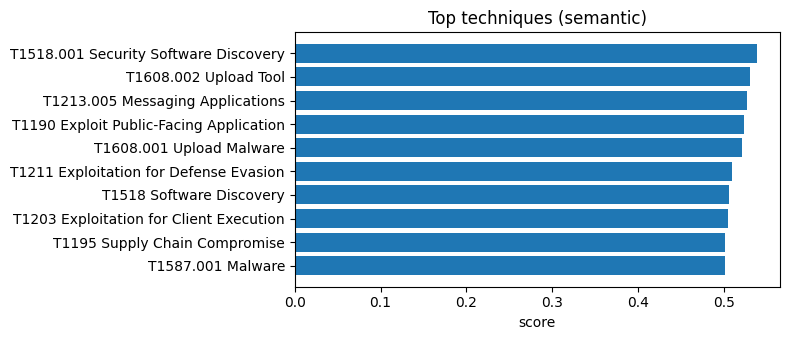

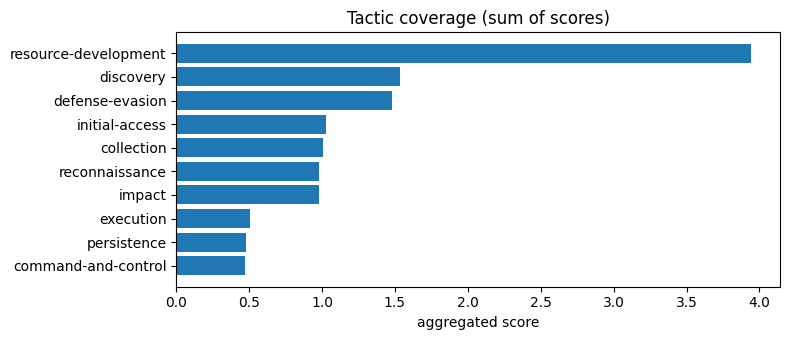

Saved layer to mitremap-layer.json


In [ ]:
# Analyze a Threat Intel report by URL
mode = "semantic"  # "semantic" or "zero-shot"
top_k = 25

ti_url = input("Paste Threat Intel report URL: ").strip()
if not ti_url:
    raise ValueError("No URL provided.")

def run_mapper(text, mode="semantic", top_k=25, layer_path="mitremap-layer.json"):
    # 1) IOCs
    iocs = extract_iocs(text)
    iocs_df = iocs_to_frame(iocs)
    print(f"Extracted {len(iocs_df)} IOCs")

    # 2) Techniques
    if mode == "semantic":
        inferred_df = semantic_rank(text, top_k=top_k)
    else:
        inferred_df = zero_shot_rank(text, top_k=top_k)

    # Show tables
    display(inferred_df.head(10))
    display(iocs_df)

    # 3) Visualization
    if not inferred_df.empty:
        plot_topk(inferred_df, title=f"Top techniques ({mode})")
        tactic_heatmap(inferred_df)
        # 4) Export Navigator layer in json format
        export_navigator_layer(inferred_df, name=f"MitreMap ({mode})", path=layer_path)
    else:
        print("No techniques inferred. Try zero-shot mode or provide more context.")
    return inferred_df, iocs_df

# Pull report text
print("Fetching:", ti_url)
ti_text = fetch_text_from_url(ti_url)
print(f"Fetched {len(ti_text):,} chars of text")
print("Preview:\n", ti_text[:200], "\n---\n")

# Run the whole pipeline
inferred_df, iocs_df = run_mapper(ti_text, mode=mode, top_k=top_k)
